# ECG Generator

That notebook generates a training set for the ECG stream anomaly detection using GAN

## Imports

In [1]:
import csv
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Data preparation

In [10]:
dataframe = pd.read_csv('C:/ecg.csv', header=None)
raw_data = dataframe.values

# get last element
labels = raw_data[:, -1]

# rest are data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

min_val =  tf.reduce_min(raw_data)
max_val = tf.reduce_max(raw_data)

train_data = (train_data - min_val)/ (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [13]:
anomalous_train_data[0]

<tf.Tensor: shape=(140,), dtype=float32, numpy=
array([0.46221596, 0.38956705, 0.34233454, 0.3219623 , 0.3235584 ,
       0.32928   , 0.34991214, 0.3835352 , 0.41554254, 0.42885196,
       0.43129066, 0.44631764, 0.47006762, 0.48265573, 0.48031566,
       0.48030686, 0.4854375 , 0.48475075, 0.47943082, 0.4815216 ,
       0.48384222, 0.48268455, 0.47841066, 0.4801475 , 0.47823322,
       0.4795395 , 0.47930655, 0.4771746 , 0.47892523, 0.47916144,
       0.47497103, 0.47325206, 0.47447628, 0.47564963, 0.47115585,
       0.4717178 , 0.4712972 , 0.4681482 , 0.46555018, 0.46350086,
       0.46137902, 0.45942375, 0.460683  , 0.46083918, 0.45756534,
       0.45728654, 0.45836332, 0.45968682, 0.45476416, 0.45586988,
       0.46005398, 0.4590618 , 0.4591953 , 0.4626668 , 0.46274665,
       0.46646643, 0.4673006 , 0.47029987, 0.47508904, 0.47988862,
       0.48404384, 0.483004  , 0.48392892, 0.483998  , 0.486767  ,
       0.48938373, 0.4871895 , 0.48920766, 0.48729578, 0.48710153,
       0.49139

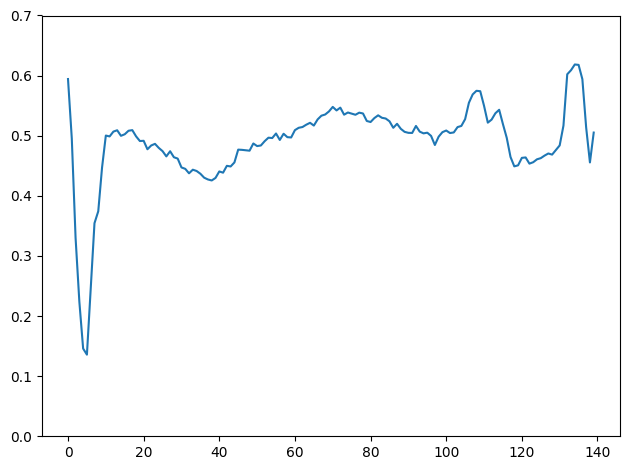

In [19]:
import matplotlib.pyplot as plt

# Create a figure and a 1x2 grid of subplots
fig, axs = plt.subplots()

# Set the figure background color to white
fig.set_facecolor('white')
x=np.arange(0,140,1)
# Plot data on the first subplot
axs.plot(x, normal_train_data[0])
axs.set_ylim(0,0.7)
# Set the title for the first subplot


# Improve the spacing between the subplots
plt.tight_layout()

# Show the plot
plt.show()

## The GAN model
Below there is a definition of GAN model that generates ECG-like data

In [3]:
def sample_generator(dataset, input_dim):
    # Define the dimensions of the data
    data = dataset

    # Define the generator model
    def build_generator():
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(256, input_dim=input_dim))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.Dense(512))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.Dense(input_dim))
        model.add(tf.keras.layers.Activation('sigmoid'))
        return model

    # Define the discriminator model
    def build_discriminator():
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(512, input_dim=input_dim))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.Dense(256))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.Dense(1))
        model.add(tf.keras.layers.Activation('sigmoid'))
        return model

    # Build the GAN model
    def build_gan(generator, discriminator):
        discriminator.trainable = False
        gan_input = tf.keras.layers.Input(shape=(input_dim,))
        generated_data = generator(gan_input)
        gan_output = discriminator(generated_data)
        gan = tf.keras.models.Model(inputs=gan_input, outputs=gan_output)
        gan.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
        return gan

    # Create instances of the generator and discriminator
    generator = build_generator()
    discriminator = build_discriminator()

    generator.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
    discriminator.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))


    gan = build_gan(generator, discriminator)

    # Training loop
    batch_size = 32
    epochs = 1000

    for epoch in range(epochs):
        # Generate random noise as input for the generator
        noise = np.random.normal(0, 1, size=(batch_size, input_dim))

        # Generate fake data using the generator
        generated_data = generator.predict(noise)

        # Get the number of data samples in your dataset
        num_samples = data.shape[0]

    # Set the number of randomly chosen data samples you want
        num_random_samples = 10

    # Randomly select indices of the data samples
        random_indices = np.random.choice(num_samples, size=num_random_samples, replace=False)

    # Retrieve the randomly chosen data samples
        random_data = []

        for i in random_indices:
            random_data.append(data[i])

    # Concatenate the real data and generated data
        x = np.concatenate((random_data, generated_data))

        # Create the labels for the discriminator
        y = np.zeros(42)
        y[:batch_size] = 1

        # Train the discriminator
        discriminator_loss = discriminator.train_on_batch(x, y)

        # Generate new random noise as input for the generator
        noise = np.random.normal(0, 1, size=(batch_size, input_dim))

        # Create labels for the generator (tricking the discriminator)
        y = np.ones(batch_size)

        # Train the generator (via the whole GAN model, with the discriminator weights frozen)
        generator_loss = gan.train_on_batch(noise, y)

        # Print the progress
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs} | Discriminator loss: {discriminator_loss} | Generator loss: {generator_loss}")
    # Generate samples using the trained generator
    return generator

## Creation of generators' models

In [4]:
normal_generator = sample_generator(normal_train_data, 140)
anomaly_generator= sample_generator(anomalous_train_data, 140)

1/1 [==============================] - 0s 121ms/step
Epoch 0/1000 | Discriminator loss: 0.8036724925041199 | Generator loss: 0.7162861227989197
1/1 [==============================] - 0s 16ms/step
Epoch 100/1000 | Discriminator loss: 0.5783770084381104 | Generator loss: 0.2973974347114563
1/1 [==============================] - 0s 31ms/step
Epoch 200/1000 | Discriminator loss: 0.5655326843261719 | Generator loss: 0.2562980651855469
1/1 [==============================] - 0s 16ms/step


KeyboardInterrupt: 

## Model exporting

In [10]:
normal_generator.save('../models/generators/normal_ecg_generator')
anomaly_generator.save('../models/generators/anomalous_ecg_generator')

INFO:tensorflow:Assets written to: models/generators/normal_ecg_generator\assets


INFO:tensorflow:Assets written to: models/generators/normal_ecg_generator\assets


INFO:tensorflow:Assets written to: models/generators/anomalous_ecg_generator\assets


INFO:tensorflow:Assets written to: models/generators/anomalous_ecg_generator\assets


## New data generating

In [5]:
normal_generator = tf.keras.models.load_model('../models/generators/normal_ecg_generator')

In [6]:
anomaly_generator = tf.keras.models.load_model('../models/generators/anomalous_ecg_generator')

In [20]:
normal_generated_data = normal_generator.predict(np.random.normal(0, 1, size=(20, 140)))

1/1 [==============================] - 0s 47ms/step


In [16]:
anomalous_generated_data = anomaly_generator.predict(np.random.normal(0,1, size=(4, 140)))

1/1 [==============================] - 0s 111ms/step


## Data postprocessing
The code below filters generated data to make them more 'natural'

In [22]:
print(normal_generated_data)

[[0.46878457 0.34683013 0.29024494 ... 0.33431327 0.44997412 0.55466014]
 [0.48783517 0.33991966 0.3658338  ... 0.37732437 0.48578694 0.5160375 ]
 [0.45275927 0.30039296 0.30718032 ... 0.42488605 0.52312696 0.54977286]
 ...
 [0.4633014  0.3846269  0.36555707 ... 0.42966214 0.58385056 0.54470843]
 [0.51844877 0.35678667 0.30654475 ... 0.39362523 0.50717694 0.5734211 ]
 [0.53386337 0.3701873  0.26504868 ... 0.36934724 0.48847428 0.55376965]]


In [17]:
def filter_data(generated_data):
    dataset = []

    for sample in generated_data:
        filtered_generated_sample = []
        filtered_generated_sample = np.append(filtered_generated_sample, scipy.signal.wiener(sample, 15))
        dataset.append(filtered_generated_sample)
    return dataset

In [18]:
normal_generated_data = filter_data(normal_generated_data)
anomalous_generated_data = filter_data(anomalous_generated_data)

In [19]:
normal_generated_data

[array([0.37108041, 0.36587953, 0.3514413 , 0.2630281 , 0.23512551,
        0.25948711, 0.35332109, 0.3702325 , 0.41204382, 0.41026467,
        0.4131502 , 0.41110629, 0.41590418, 0.43271381, 0.44146943,
        0.45266105, 0.44683203, 0.44506782, 0.44476187, 0.44490894,
        0.45886047, 0.45961105, 0.45848323, 0.456831  , 0.45627929,
        0.45954082, 0.46575247, 0.46246594, 0.45724332, 0.45633213,
        0.45357043, 0.46580412, 0.4617022 , 0.45548883, 0.45234513,
        0.44548047, 0.44755016, 0.44774353, 0.45738253, 0.46630879,
        0.4694721 , 0.47233907, 0.48284567, 0.48864799, 0.48931277,
        0.49080415, 0.48015066, 0.48805523, 0.48985334, 0.4948437 ,
        0.49772114, 0.50444543, 0.50260431, 0.49426436, 0.49243542,
        0.48719018, 0.48704799, 0.48469629, 0.48352063, 0.48971982,
        0.4894269 , 0.49615313, 0.49287979, 0.50018351, 0.49776907,
        0.49782797, 0.49188621, 0.49883379, 0.51131045, 0.51217113,
        0.51169621, 0.51235659, 0.50479349, 0.50

In [ ]:
autoencoder_model = tf.keras.models.load_model('../models/detectors/autoencoder')
ann_model = tf.keras.models.load_model('../models/detectors/ann')

## Data labeling

In [11]:
new_column = np.ones(20000)
normal_generated_data = np.concatenate((normal_generated_data, new_column[:, np.newaxis]), axis=1)
new_column = np.zeros(4000)
anomalous_generated_data = np.concatenate((anomalous_generated_data, new_column[:, np.newaxis]), axis=1)

## Creation of training dataset

In [12]:
generated_data = np.concatenate((normal_generated_data, anomalous_generated_data), axis=0)
np.random.shuffle(generated_data)

## Training dataset exporting

In [14]:
with open('../dataset/ecg_2.csv', 'w', encoding='UTF-8', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(generated_data)